In [1]:
from mudata import MuData
import numpy as np
from anndata import AnnData

from pymnet import *
import scanpy

rng = np.random.default_rng(seed=42)
%matplotlib inline

# Old notebook, will be integrated into type_conversions

In [2]:
def link_MuData(mu):
    #load indivdual connectivites
    #for adata in mu:
    #adata.osbp["connectivities"]

    #compute or load layer linkage
    #mdata.obsp["conncetivities"]

    return None

def map2layers(mu,i,j):
    input_edge = [mod for mod in mu.mod if mu.obsm[mod][i]]
    output_edge = [mod for mod in mu.mod if mu.obsm[mod][j]]
    return input_edge, output_edge
        

def Mu2Net(mu):
    obs = list(mu.obs.index)
    net = MultilayerNetwork(aspects=1)
    for mod in reversed(mu.mod):
        net.add_layer(mod,1)

    for x, _  in enumerate(mu.obsp["connectivities"]):
        for y, edge  in enumerate(mu.obsp["connectivities"][x,:]):
            if edge > 0:
                input,output = map2layers(mu,x,y)
                for i in input:
                    for o in output:
                        net[obs[x],obs[y],i,o] = mu.obsp["connectivities"][x,y]
    return net
    '''
        print(mod)
        print(mu.obsm[mod])
        for i,obs in enumerate(mu.obs.index):
            
            if mu.obsm[mod][i]:
                net[obs] = 1
                #net.add_node(obs,mod)
                #print(net[obs,mod])
                
        #print(net.iter_nodes[mod])
        print(list(net.iter_node_layers()))
    
    #obs to nodes
    #intralayer obs connection from vars
    #interlayer obs connection from obsm["mapping"]
    '''
    


### Create MuData
1. Set params
2. Generate example graphs
3. Store as AnnData objects 
4. Combine to a single MuData object


In [3]:
n_spots = 1 #number of spots
n_cells = 10 #number of cells
n_genes = 100 #number of genes
k = 10 #discrete values for genes

In [4]:
#Generate example spot2spot
z = rng.normal(loc=np.arange(k), scale=np.arange(k)*2, size=(n_spots,k))
w = rng.normal(size=(n_genes,k))
y = np.dot(z, w.T)
y.shape

#Create AnnData
spatial_data = AnnData(y)
spatial_data.obs_names = [f"s{i+1}" for i in range(n_spots)]
spatial_data.var_names = [f"spot_gene_{j+1}" for j in range(n_genes)]
spatial_data

#Generate example cell2cell
z2 = rng.normal(loc=np.arange(k), scale=np.arange(k)*2, size=(n_cells,k))
w2 = rng.normal(size=(n_genes,k))
y2 = np.dot(z2, w2.T)

#Create AnnData
exp_data = AnnData(y2)
exp_data.obs_names = [f"c{i+1}" for i in range(n_cells)]
exp_data.var_names = [f"cell_gene_{j+1}" for j in range(n_genes)]
exp_data


#Generate example layer linkage
all_obs = n_spots + n_cells
spot2cell = rng.random(size=(n_spots,n_cells))
cell2spot = rng.random(size=(n_cells,n_spots))
mapping = np.zeros((all_obs,all_obs))
mapping[:n_spots,-n_cells:] = spot2cell
mapping[-n_cells:,:n_spots] = cell2spot

#Create MuData 
mdata = MuData({"Spots": spatial_data, "Cells": exp_data})
mdata.obsp["connectivities"]= mapping
mdata

MuData object with n_obs × n_vars = 11 × 200
  obsp:	'connectivities'
  2 modalities
    Spots:	1 x 100
    Cells:	10 x 100

In [5]:
mdata.obsp

PairwiseArrays with keys: connectivities

### MuData <-> Multilayer Graph Object

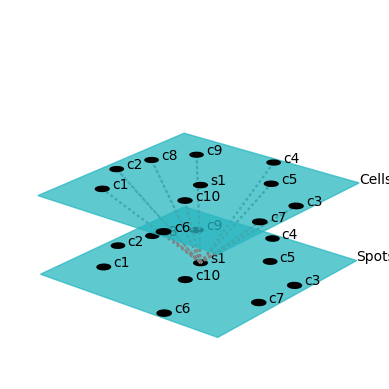

In [6]:
#Transforms mdata object into multilayer graph object (currently pymnet, but it s*cks)
net = Mu2Net(mdata)

#Draw multilayer graph object
fig = draw(net,show=True,layout="spring")